<a href="https://colab.research.google.com/github/gaurav-jo1/Machine-Learning-Essentials/blob/main/pytorch/computer_vision_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Changes

1. Optimizer(momentum=0.9) update

In [2]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

# Download training and test datasets
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

class_names = train_dataset.classes

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.96MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
random_num = random.randint(0, 60000)
image, label = train_dataset[random_num]
print(f"Image shape: {image.shape}")
print(f"random_num: {random_num}")

Image shape: torch.Size([1, 28, 28])
random_num: 31009


(-0.5, 27.5, 27.5, -0.5)

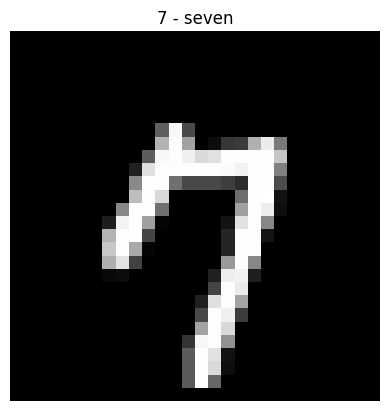

In [6]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

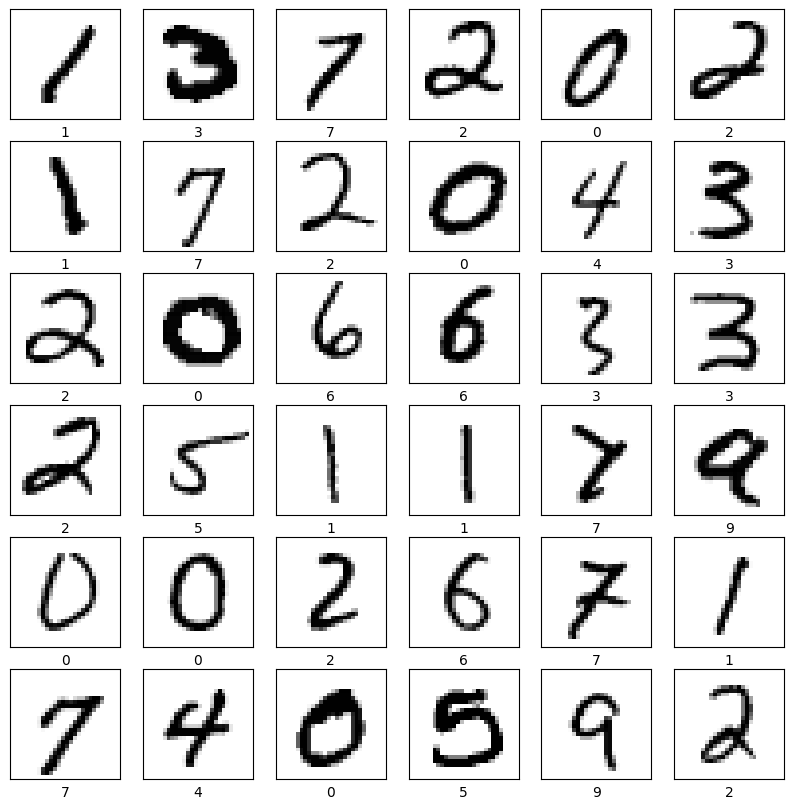

In [7]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    image, label = train_dataset[image_ind]
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)
    plt.xlabel(label)

In [8]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [9]:
from helper_functions import accuracy_fn

In [10]:
BATCH_SIZE = 32

NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [11]:
class VGG16(nn.Module):
  def __init__(self, input_shape:int, output_shape:int, hidden_units: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            input_shape,
            hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            hidden_units,
            hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
        )

  def forward(self, x):
    x = self.conv_block_1(x)

    x = self.conv_block_2(x)

    x = self.classifier(x)

    return x
    # return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))

In [12]:
torch.manual_seed(42)

model_0 = VGG16(input_shape=1, output_shape=len(class_names), hidden_units=10).to(device)
model_0

VGG16(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [13]:
summary(model_0, (1, 28, 28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 10, 28, 28]             910
              ReLU-4           [-1, 10, 28, 28]               0
         MaxPool2d-5           [-1, 10, 14, 14]               0
            Conv2d-6           [-1, 10, 14, 14]             910
              ReLU-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             910
              ReLU-9           [-1, 10, 14, 14]               0
        MaxPool2d-10             [-1, 10, 7, 7]               0
          Flatten-11                  [-1, 490]               0
           Linear-12                   [-1, 10]           4,910
Total params: 7,740
Trainable params: 7,740
Non-trainable params: 0
-----------------------------------

In [14]:
def train_step(model: nn.Module,
          optimizer: optim.Optimizer,
          dataloader: DataLoader,
          loss_fn: nn.Module,
          device: torch.device):
  # model.to(device)
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # print(f"X: {X.shape} | {len(y)}")

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    # print(f"Loss: {loss}")
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    train_acc += accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [15]:
# model = VGG16(input_shape=1, output_shape=len(class_names), hidden_units=10).to(device)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

# train_step(model=model,optimizer=optimizer, dataloader=train_dataloader, loss_fn=loss_fn, device=device)

In [16]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_acc += accuracy_fn(y_true=y,y_pred=test_pred_logits.argmax(dim=1))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [17]:
from tqdm.auto import tqdm

def train(model: nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          optimizer: optim.Optimizer,
          loss_fn: nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, optimizer=optimizer, dataloader=train_dataloader, loss_fn=loss_fn, device=device)

        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f}% | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}%"
        )

        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    return results

In [18]:
NUM_EPOCHS = 4

model = VGG16(input_shape=1, output_shape=len(class_names), hidden_units=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [19]:
model_results = train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0228 | train_acc: 65.4050% | test_loss: 0.2048 | test_acc: 93.8898%
Epoch: 2 | train_loss: 0.1646 | train_acc: 95.0467% | test_loss: 0.1089 | test_acc: 96.5555%
Epoch: 3 | train_loss: 0.1102 | train_acc: 96.5700% | test_loss: 0.0918 | test_acc: 96.9748%
Epoch: 4 | train_loss: 0.0908 | train_acc: 97.2600% | test_loss: 0.0808 | test_acc: 97.3942%


# Evaluation

In [40]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    model.to(device)
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
          X, y = X.to(device), y.to(device)
          y_pred = model(X)

          loss += loss_fn(y_pred, y)
          acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

model_evaluation = eval_model(model=model, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

model_evaluation

{'model_name': 'VGG16',
 'model_loss': 0.08081192523241043,
 'model_acc': 97.39416932907348}

In [20]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

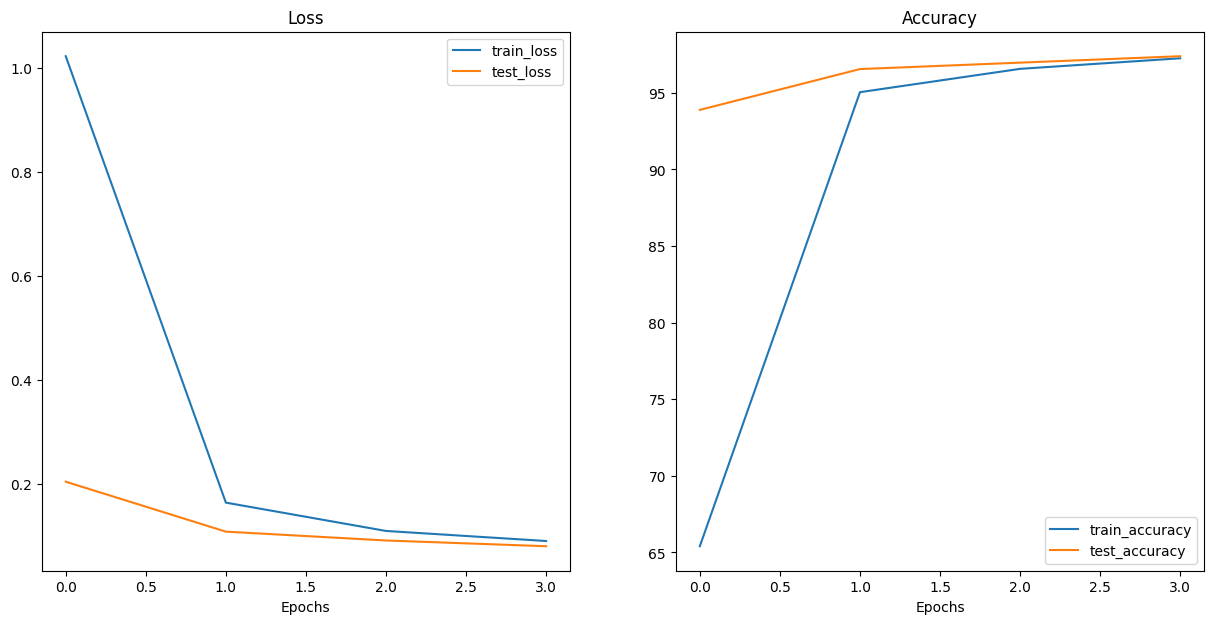

In [21]:
plot_loss_curves(model_results)

In [22]:
def make_predection(model: torch.nn.Module, data:list, device: torch.device= device):
  pred_probs = []
  model.eval()

  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logits = model(sample)

      # Get the prediction probability (Logits -> Prediction probability)

      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [23]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, '0 - zero')

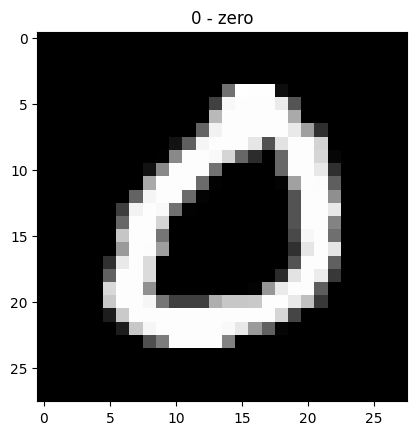

In [24]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [25]:
pred_probs = make_predection(model=model, data=test_samples)

In [26]:
pred_classes = pred_probs.argmax(dim=1)

In [27]:
pred_classes

tensor([0, 2, 4, 4, 2, 1, 6, 5, 5])

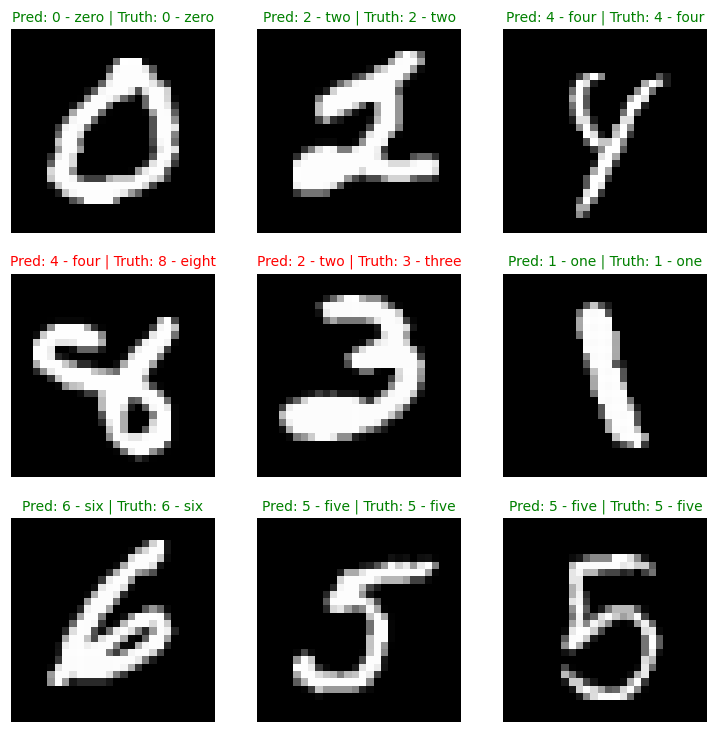

In [28]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

# Confusion Matrix

In [29]:
from tqdm.auto import tqdm

y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making prediction."):
    X, y = X.to(device), y.to(device)

    y_logits = model(X)

    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making prediction.:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [30]:
try:
    import torchmetrics
except:
  !pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 24.5 MB/s eta 0:00:00


In [31]:
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [32]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

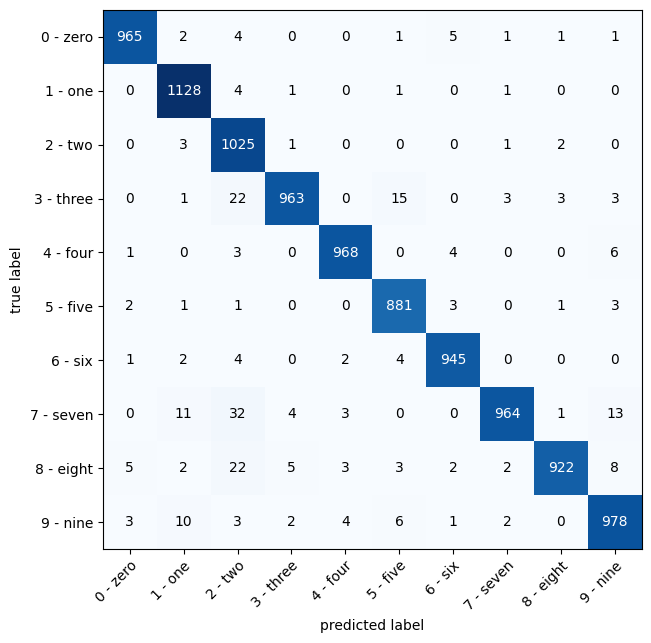

In [33]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
comfmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = comfmat(preds=y_pred_tensor, target=test_dataset.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

# Save and Load Best Performing Model

In [35]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "computer_vision_MNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/computer_vision_MNIST.pth


In [43]:
loaded_model = VGG16(input_shape=1, output_shape=len(class_names), hidden_units=10)

loaded_model.load_state_dict(
    torch.load(MODEL_SAVE_PATH)
)

loaded_model.to(device)

<ipython-input-43-de884d349106>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(MODEL_SAVE_PATH)


VGG16(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [44]:
loaded_model_result = eval_model(
    model=loaded_model,
    data_loader= test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

In [45]:
loaded_model_result

{'model_name': 'VGG16',
 'model_loss': 0.08081192523241043,
 'model_acc': 97.39416932907348}